In [2]:
import numpy as np

In [3]:
print("hello World!")

hello World!


In [4]:
x = 0.1
y = 0.3



In [5]:
if x < y:
    print("x t'as fumé ta race!!!!")

x t'as fumé ta race!!!!


# J'ai juste créer ce petit notebook pour voir si on allait réussir a utiliser Jupyter notebook et Git de manière stylée cette fois

In [1]:
import numpy as np
import pandas as pd
import re # Used for the conversion of "r##_c##" in only the numbers --> TODO: check where it comes from
from helpers import *
from play_with_data import *


In [2]:
#********* Load the given data **********
r_c, x = load_data('./data_train.csv')

In [3]:
#********* Creation of a matrix of the data ********
nUser = 10000
nItem = 1000
data = np.zeros([nUser, nItem]) # These numbers were given

for ind, i in enumerate(r_c): # Loop over all the ID 
    data[int(re.findall('\d+', i)[0])-1, int(re.findall('\d+', i)[1])-1] = x[ind] # Use the information in the ID (row, col) to create the matrix




The number of zero in the data given:	0
The number of ratings we have:			1176952
The number of missing values we expected:	8823048
The number of missing values:			8823048
Pourcentage of missing values:	88.23048 %
Pourcentage of good values:	11.76952 %

The loading of the data is well done


The ratings 1 is present 43508 times
The ratings 2 is present 99180 times
The ratings 3 is present 274327 times
The ratings 4 is present 324700 times
The ratings 5 is present 435237 times


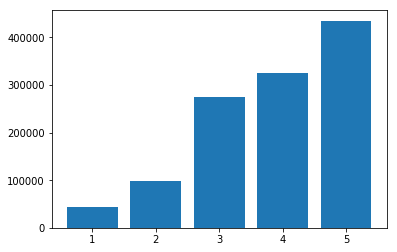

In [8]:
# Check if there is any missed data 
# It was told us that we have the data from 10'000 users for 1000 films, but we don't have all these data
info_general(nUser, nItem, x, data)
print('\n')
info_ratings(data)


In [9]:
#********** Data preview ************
